<a href="https://colab.research.google.com/github/aderdouri/ActuarialThesis/blob/master/Notebooks/myCatBoostClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Catboost

## Cloner la branche contenant le dataset le code qui va avec.

In [ ]:
!rm -rf ActuarialThesis
!git clone https://github.com/aderdouri/ActuarialThesis.git
%ls -ltr ActuarialThesis

Cloning into 'ActuarialThesis'...
remote: Enumerating objects: 805, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 805 (delta 41), reused 63 (delta 25), pack-reused 717
Receiving objects: 100% (805/805), 123.08 MiB | 15.54 MiB/s, done.
Resolving deltas: 100% (331/331), done.
total 96
drwxr-xr-x 2 root root  4096 Oct 16 18:02 AllstateClaimPredictionChallenge/
drwxr-xr-x 2 root root  4096 Oct 16 18:02 AllstateClaimsSeverity/
drwxr-xr-x 2 root root  4096 Oct 16 18:02 Data/
drwxr-xr-x 2 root root  4096 Oct 16 18:02 EMTboost/
drwxr-xr-x 2 root root  4096 Oct 16 18:02 FrenchMotorThirdPartyLiabilityClaims/
drwxr-xr-x 2 root root  4096 Oct 16 18:02 Models/
drwxr-xr-x 2 root root  4096 Oct 16 18:02 Notebooks/
drwxr-xr-x 2 root root  4096 Oct 16 18:02 src/
-rw-r--r-- 1 root root    54 Oct 16 18:02 README.md
drwxr-xr-x 2 root root  4096 Oct 16 18:02 Plots/
-rw-r--r-- 1 root root 19545 Oct 16 18:02 myXGBoostRegressor.ipynb
-rw-r--

In [ ]:
!mkdir ActuarialThesis/plots_clf
!ls -ltr ActuarialThesis/plots_clf

total 0


In [ ]:
# Ajouter le répértoire src
import sys
sys.path.insert(0,'./ActuarialThesis/src/')

In [ ]:
import installHelper

In [ ]:
print(list(dir(installHelper)))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'installALL', 'subprocess', 'sys']


In [ ]:
!ls -ltr

total 8
drwxr-xr-x  1 root root 4096 Oct 13 13:22 sample_data
drwxr-xr-x 13 root root 4096 Oct 16 18:02 ActuarialThesis


# Installer les packages nécéssaires

In [ ]:
%time installHelper.installALL()

CPU times: user 297 ms, sys: 61.2 ms, total: 358 ms
Wall time: 1min 45s


In [ ]:
# On doit trouver tous les packages mentionés dans le grep
!pip list -v | grep -e catboost -e 'imbalanced-learn' -e 'optuna' -e 'catboost' -e 'lime' -e 'shap' -e 'kaleido' -e 'scikitplot'

catboost                         1.2.2                 /usr/local/lib/python3.10/dist-packages pip
imbalanced-learn                 0.10.1                /usr/local/lib/python3.10/dist-packages pip
kaleido                          0.2.1                 /usr/local/lib/python3.10/dist-packages pip
lime                             0.2.0.1               /usr/local/lib/python3.10/dist-packages pip
optuna                           3.3.0                 /usr/local/lib/python3.10/dist-packages pip
shap                             0.43.0                /usr/local/lib/python3.10/dist-packages pip
shapely                          2.0.1                 /usr/local/lib/python3.10/dist-packages pip


# Importer les packages nécéssaires

In [ ]:
from helper import *

In [ ]:
# Appliquer le theme par défaut
sns.set_theme()

# Partir du dataset déja encodé.

In [ ]:
# Partir du dataset déja encodé.
df = pd.read_csv('ActuarialThesis/Data/encodedBASEAUTO.csv')
df.head()

,ACV,SEX,STATUT,AGECOND,K8000,RM,CAR,USAGE_Prive,USAGE_PriveTrajet,USAGE_Professionnel,...,SEGM_H,SEGM_M1,SEGM_M2,GARAGE_ClosCollectif,GARAGE_GarageAutre,GARAGE_IndividuelClos,CSP_CSP_50,CSP_CSP_60,CSP_CSP_AUTRE,CHARGE
0,1.134929,1,1,-0.457663,0,-0.094064,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.134929,1,0,1.101165,0,-0.817279,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.134929,1,1,-1.813166,0,1.507343,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.134929,1,0,0.626739,0,-0.817279,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.134929,1,0,-1.203190,0,1.507343,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# Separation de la variable target du dataset
Y = df['CHARGE']
X = df.drop('CHARGE', axis=1)

# Target variable mapping

In [ ]:
# Ici nous allons considérer le problème comme un problème de classification
# Class 0 si la CHARGE==0 sinon Class 1.
y = Y.map(lambda val: 0 if val<=0 else 1)

In [ ]:
y.unique()

array([0, 1])

# Modeling

In [ ]:
import numpy as np
import optuna
from optuna.integration import CatBoostPruningCallback

import catboost as cb
from sklearn.metrics import accuracy_score, f1_score, average_precision_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))


def objective(trial: optuna.Trial) -> float:

    param = {
        "verbose": 0,
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),

        "eval_metric": trial.suggest_categorical("eval_metric", ["PRAUC"]),
        "class_weights": trial.suggest_categorical("class_weights", [class_weights, class_weights]),
        "used_ram_limit": "3gb"
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = cb.CatBoostClassifier(**param)

    pruning_callback = CatBoostPruningCallback(trial, "PRAUC")
    gbm.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=0,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )

    # evoke pruning manually.
    pruning_callback.check_pruned()

    preds = gbm.predict(X_val)
    pred_labels = np.rint(preds)
    #return accuracy_score(y_val, pred_labels)
    #return f1_score(y_val, pred_labels)

    return average_precision_score(y_val, pred_labels)

In [ ]:
study = optuna.create_study(
  pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
)
study.optimize(objective, n_trials=20)#, timeout=600)

In [ ]:
cb_hp = study.best_params
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 20
Best trial:
  Value: 0.21826045896873647
  Params: 
    objective: Logloss
    colsample_bylevel: 0.023724231479604445
    depth: 6
    boosting_type: Plain
    bootstrap_type: Bayesian
    eval_metric: PRAUC
    class_weights: {0: 0.5755941499085924, 1: 3.8071342200725513}
    bagging_temperature: 4.0324666615796465


In [ ]:
optimized_cb_clf = cb.CatBoostClassifier(**cb_hp)
optimized_cb_clf.fit(X_train, y_train, verbose=0)

In [ ]:
y_pred = optimized_cb_clf.predict(X_test)
print(classification_report(y_test, y_pred))
print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.93      0.61      0.74      1814
           1       0.22      0.70      0.34       286

    accuracy                           0.63      2100
   macro avg       0.57      0.65      0.54      2100
weighted avg       0.83      0.63      0.68      2100

Accuracy (balanced): 0.65496


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.write_image("./ActuarialThesis/plots_clf/myCatBoostClassifierParamImportances.pdf")
fig.show()

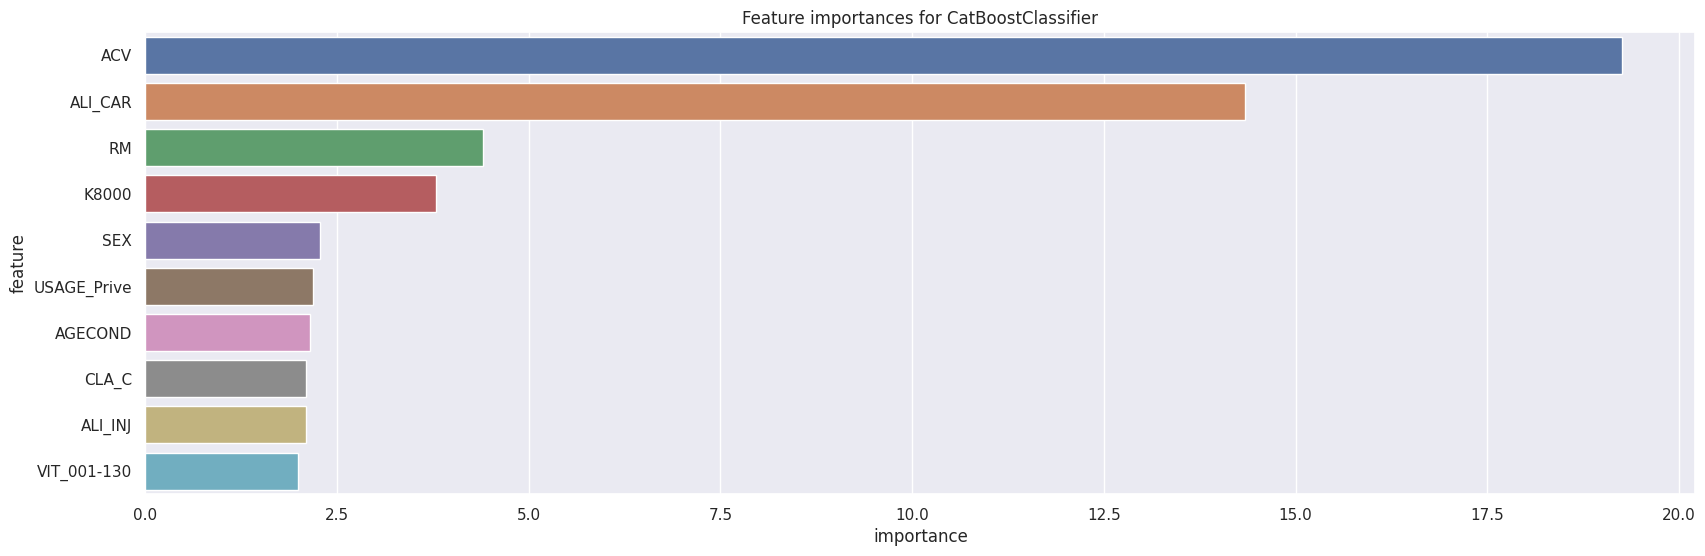

In [ ]:
feature_importances = zip(X_train.columns, optimized_cb_clf.feature_importances_)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
feature_importances = pd.DataFrame(feature_importances, columns=['feature', 'importance'])

fig = plt.gcf()
fig.figure.set_size_inches(20, 6)
plt.title('Feature importances for CatBoostClassifier')
sns.barplot(x='importance', y='feature', data=feature_importances[:10])
plt.savefig('./ActuarialThesis/plots_clf/myCatBoostClassifierFeatureImportances.pdf')

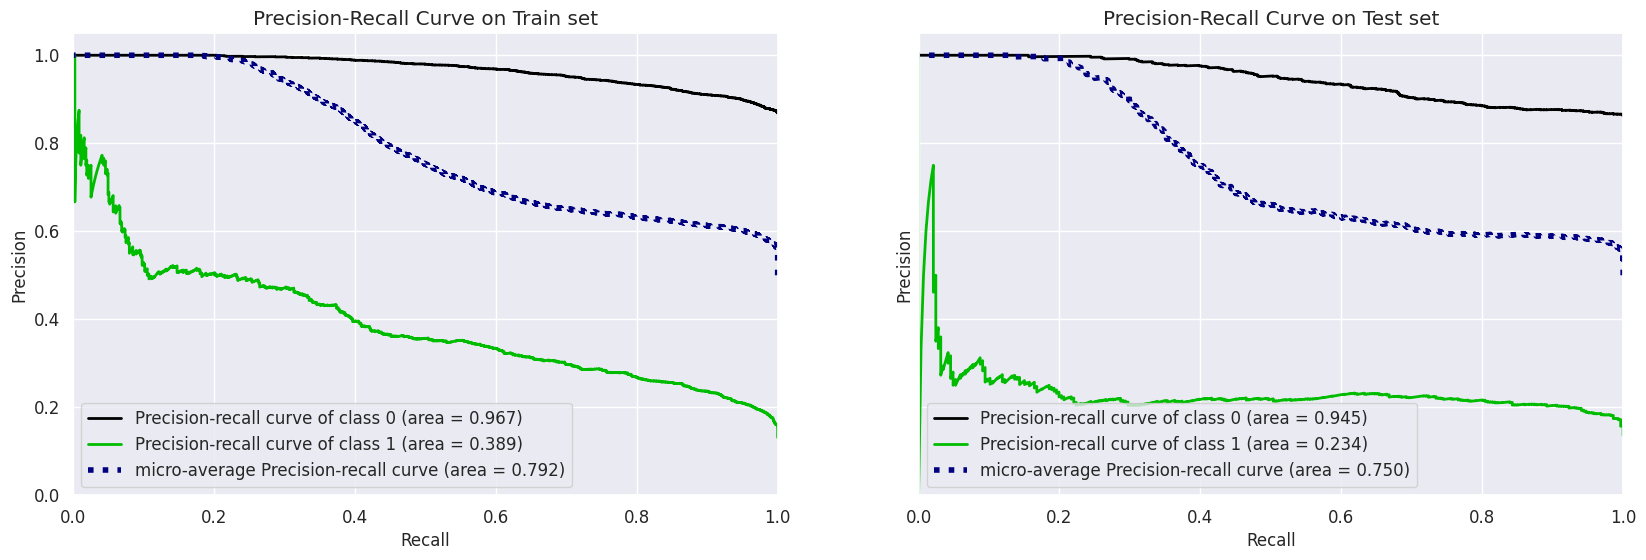

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18, 6))
y_probas = optimized_cb_clf.predict_proba(X_train)
skplt.metrics.plot_precision_recall(y_train, y_probas, ax = ax1, title = 'Precision-Recall Curve on Train set')

y_probas = optimized_cb_clf.predict_proba(X_test)
skplt.metrics.plot_precision_recall(y_test, y_probas, ax = ax2, title = 'Precision-Recall Curve on Test set')

fig.set_size_inches(20, 6)
fig.savefig('./ActuarialThesis/plots_clf/myCatBoostClassifierPrecisionRecallCurve.pdf', bbox_inches='tight')
plt.show();

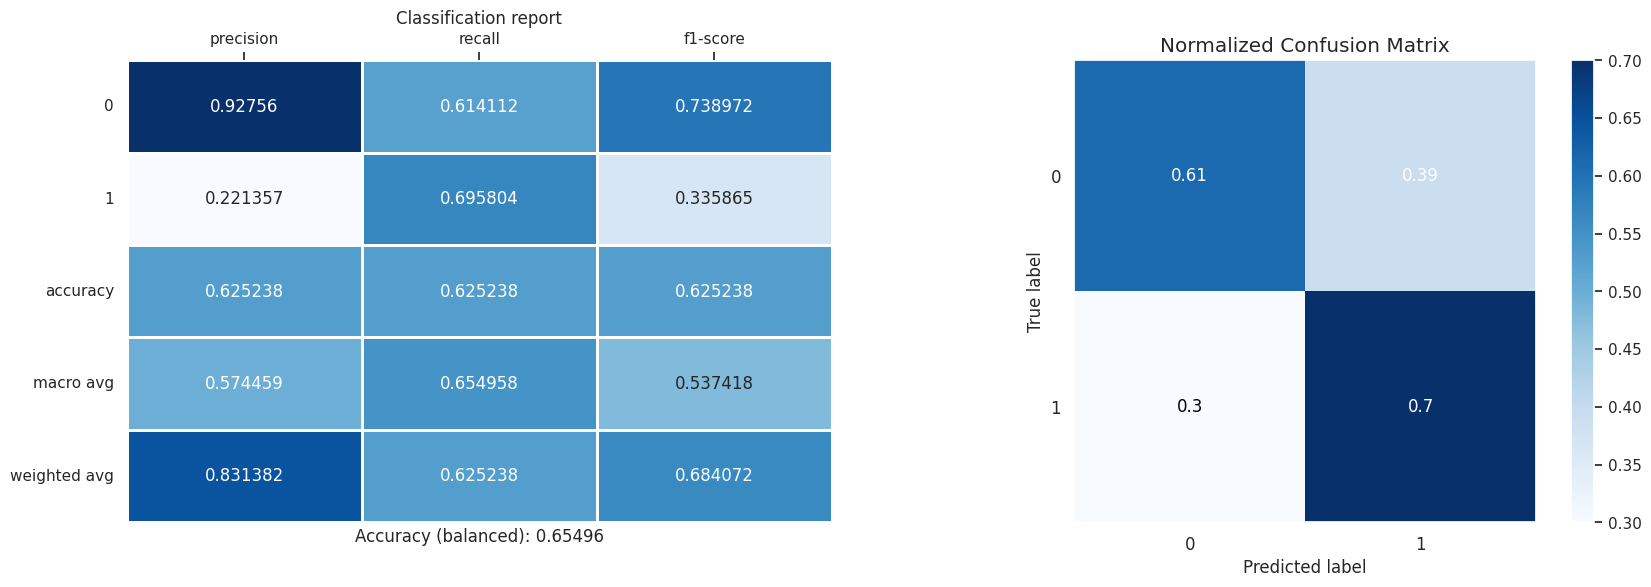

In [ ]:
fig = plot_classification_report_confusion_matrix(optimized_cb_clf, X_test, y_test)
fig.set_size_inches(20, 6)
fig.savefig('./ActuarialThesis/plots_clf/myCatBoostClassifierConfusionMatrix.pdf', bbox_inches='tight')

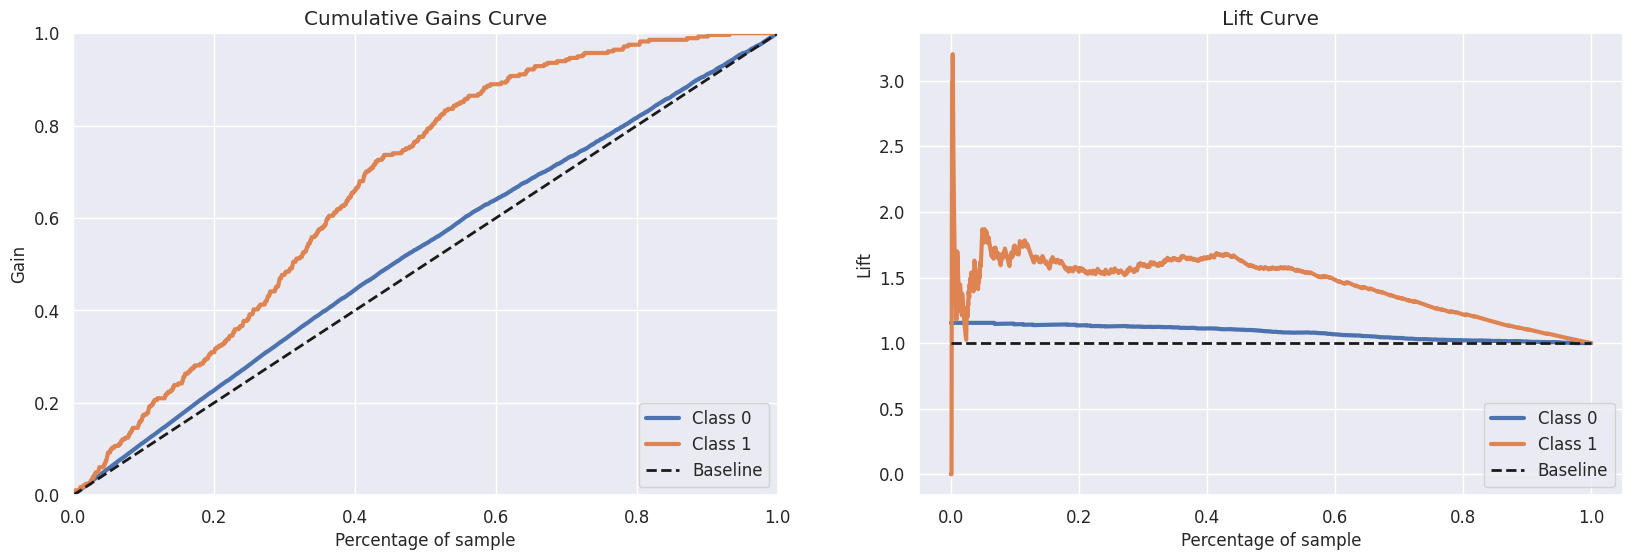

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
y_probas = optimized_cb_clf.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, y_probas, ax = ax1)
skplt.metrics.plot_lift_curve(y_test, y_probas, ax = ax2)
fig.set_size_inches(20, 6)
fig.savefig('./ActuarialThesis/plots_clf/myCatBoost_cumulative_gain_lift_curve.pdf', bbox_inches='tight')
plt.show();